<a href="https://colab.research.google.com/github/AhlamBashiti1/MedCUI_ML_Project/blob/main/biobert_cui_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Install Required Libraries
!pip install pandas scikit-learn matplotlib seaborn

In [2]:
#Import Libraries
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

In [6]:
#Upload Files
uploaded = files.upload()  # Upload biobert_embeddings.npy and cui_with_embeddings.csv

Saving biobert_embeddings.npy to biobert_embeddings (1).npy
Saving cui_with_embeddings.csv to cui_with_embeddings.csv


In [7]:
#Load Embeddings and Metadata
embeddings = np.load("biobert_embeddings.npy")
df = pd.read_csv("cui_with_embeddings.csv")

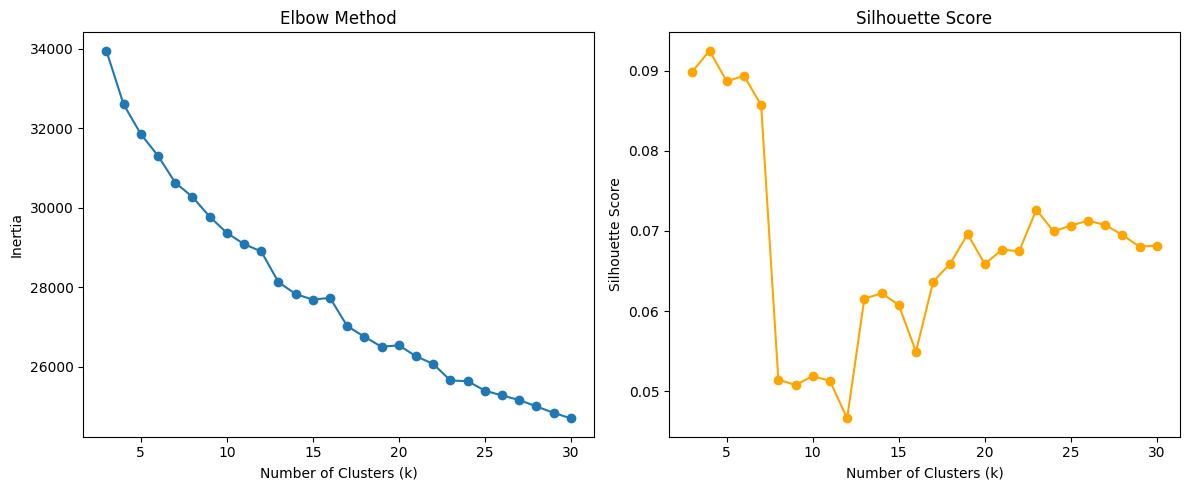


Best silhouette k: 4


In [41]:
# Heuristically Evaluate k Range
inertia = []
sil_scores = []
k_range = range(3, 31)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(embeddings, labels))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")

plt.subplot(1, 2, 2)
plt.plot(k_range, sil_scores, marker='o', color='orange')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")
plt.tight_layout()
plt.show()

best_k = k_range[sil_scores.index(max(sil_scores))]
print(f"\nBest silhouette k: {best_k}")

In [11]:
#Final Clustering
kmeans = KMeans(n_clusters=best_k, random_state=42)
df["cluster"] = kmeans.fit_predict(embeddings)

In [12]:
#Define Helper Function to Find Cluster Representatives
def find_cluster_representatives(embeddings, labels, k):
    representatives = []
    for cluster_id in range(k):
        cluster_points = embeddings[labels == cluster_id]
        cluster_mean = cluster_points.mean(axis=0)
        distances = cdist(cluster_points, [cluster_mean], metric='euclidean')
        closest_idx = np.argmin(distances)
        global_idx = np.where(labels == cluster_id)[0][closest_idx]
        representatives.append(global_idx)
    return representatives

In [13]:
#Find Representatives and Mark in DataFrame
representative_indices = find_cluster_representatives(embeddings, df["cluster"].values, best_k)
df["is_representative"] = [i in representative_indices for i in range(len(df))]

print("Representative CUIs per cluster:")
for i, idx in enumerate(representative_indices):
    print(f"Cluster {i}: {df.loc[idx, 'Canonical name']}")

Representative CUIs per cluster:
Cluster 0: Lobular
Cluster 1: Bronchopulmonary Sequestration
Cluster 2: Structure of iliac artery
Cluster 3: Renal sinus


/tmp/ipython-input-39-2883963566.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette="tab10")


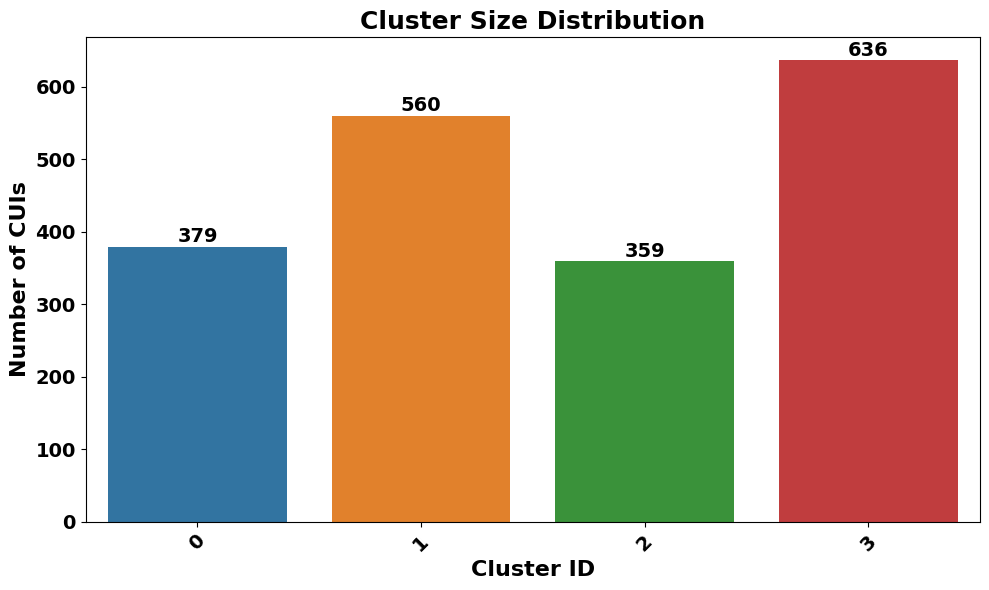


**Max cluster size:** **636**  
**Min cluster size:** **359**  
**Mean cluster size:** **483.50**  
**Median cluster size:** **469.5**  
**Max/Min ratio:** **1.77**  

**Balance status:** ✅ **The cluster sizes are fairly balanced.**


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Cluster sizes
cluster_sizes = df["cluster"].value_counts().sort_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette="tab10")

# Axis labels and title - larger and bold
ax.set_xlabel("Cluster ID", fontsize=16, fontweight='bold')
ax.set_ylabel("Number of CUIs", fontsize=16, fontweight='bold')
ax.set_title("Cluster Size Distribution", fontsize=18, fontweight='bold')

# Rotate x ticks and make them larger and bold
plt.xticks(rotation=45, fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

# Add text labels on top of bars, larger and bold
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height + max(cluster_sizes)*0.01,  # small offset above the bar
        f'{int(height)}',
        ha="center",
        fontsize=14,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

from IPython.display import display, Markdown

max_size = cluster_sizes.max()
min_size = cluster_sizes.min()
mean_size = cluster_sizes.mean()
median_size = cluster_sizes.median()
ratio = max_size / min_size

balance_threshold = 2.0
balance_msg = (
    " **The cluster sizes are fairly balanced.**"
    if ratio <= balance_threshold
    else " **The cluster sizes are imbalanced.**"
)

summary_text = f"""
**Max cluster size:** **{max_size}**
**Min cluster size:** **{min_size}**
**Mean cluster size:** **{mean_size:.2f}**
**Median cluster size:** **{median_size}**
**Max/Min ratio:** **{ratio:.2f}**

**Balance status:** {balance_msg}
"""

display(Markdown(summary_text))



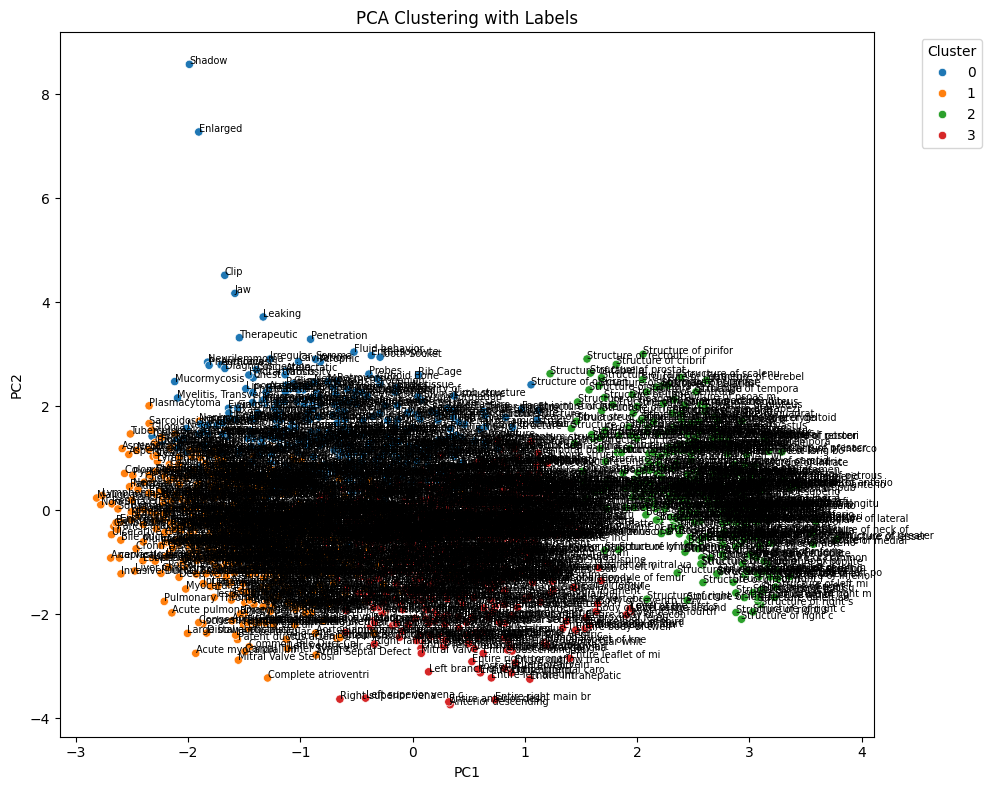

In [15]:
#PCA Visualization
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(embeddings)
df["PC1"], df["PC2"] = pca_coords[:, 0], pca_coords[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x="PC1", y="PC2", hue="cluster", palette="tab10", legend='full')

for i in range(len(df)):
    plt.text(df["PC1"][i], df["PC2"][i], str(df["Canonical name"][i])[:20], fontsize=7)

plt.title("PCA Clustering with Labels")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

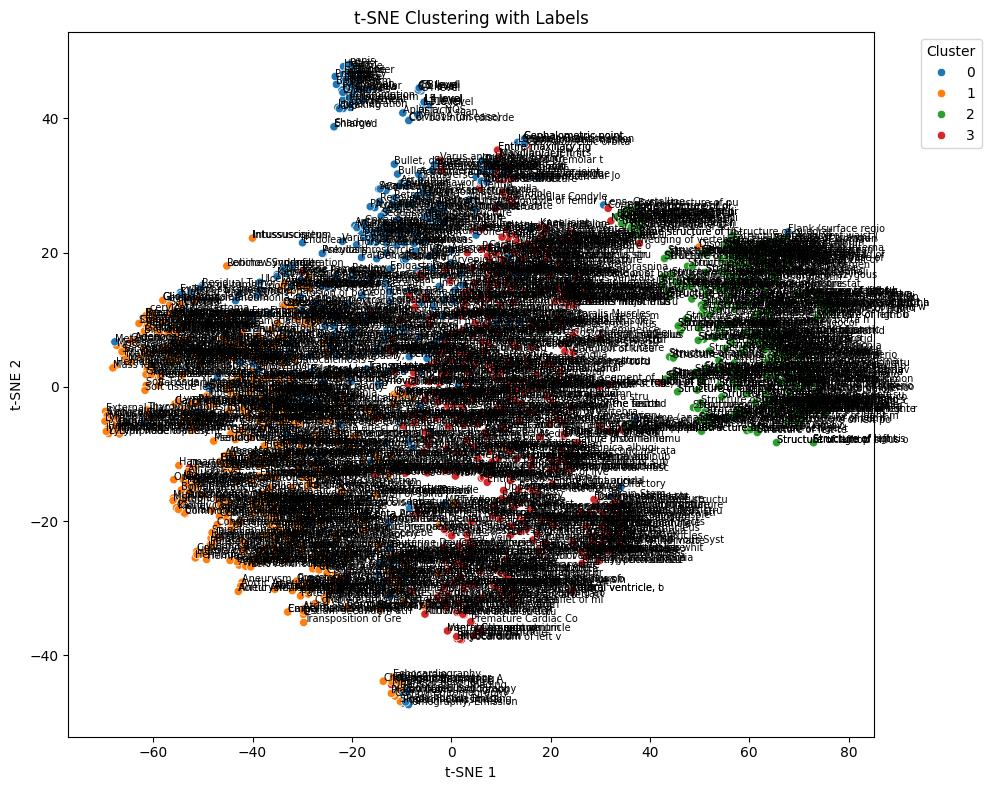

In [16]:
#t-SNE Visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_coords = tsne.fit_transform(embeddings)
df["TSNE1"], df["TSNE2"] = tsne_coords[:, 0], tsne_coords[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x="TSNE1", y="TSNE2", hue="cluster", palette="tab10", legend='full')

for i in range(len(df)):
    plt.text(df["TSNE1"][i], df["TSNE2"][i], str(df["Canonical name"][i])[:20], fontsize=7)

plt.title("t-SNE Clustering with Labels")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [20]:
# Save Results
df.to_csv("clustered_cui2.csv", index=False)
rep_df = df[df["is_representative"]]
rep_df.to_csv("cluster_representatives2.csv", index=False)

files.download("clustered_cui2.csv")
files.download("cluster_representatives2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-27-718003844.py:26: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


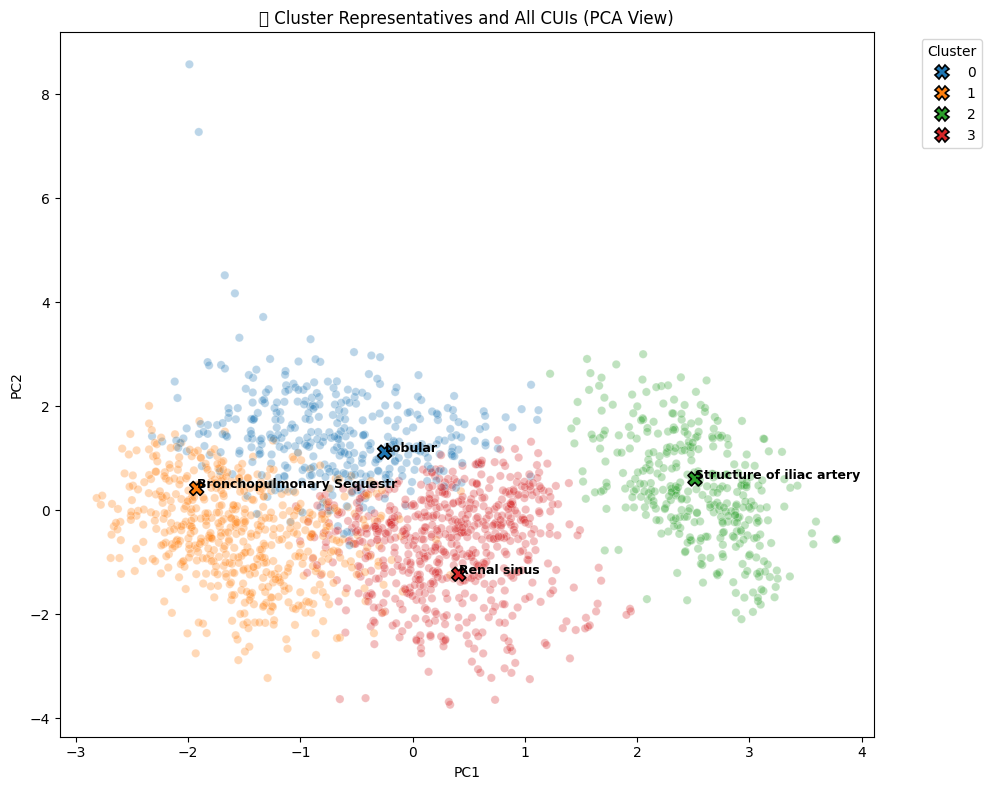

In [27]:
# Split data into representatives and others
rep_coords = df[df["is_representative"] == True]
other_coords = df[df["is_representative"] == False]

# Plot setup
plt.figure(figsize=(10, 8))

# Plot all other CUIs as small gray dots
sns.scatterplot(data=other_coords, x="PC1", y="PC2", hue="cluster", palette="tab10", alpha=0.3, legend=None)

# Plot representatives as bold X markers
sns.scatterplot(data=rep_coords, x="PC1", y="PC2", hue="cluster", palette="tab10", s=100, marker="X", edgecolor='black', linewidth=1.2)

# Add canonical name labels only for representatives
for i in range(len(rep_coords)):
    name = str(rep_coords.iloc[i]["Canonical name"])[:25]
    x = rep_coords["PC1"].iloc[i]
    y = rep_coords["PC2"].iloc[i]
    plt.text(x, y, name, fontsize=9, weight="bold")

# Final plot styling
plt.title("Cluster Representatives and All CUIs (PCA View)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [40]:
from collections import Counter

# Initialize empty list to hold cluster summary rows
summary_data = []

# Loop over each cluster
for cluster_id in sorted(df["cluster"].unique()):
    cluster_df = df[df["cluster"] == cluster_id]

    # Representative row (where is_representative is True)
    rep_row = cluster_df[cluster_df["is_representative"] == True].iloc[0]

    # Top 3 most frequent canonical names in the cluster
    name_counts = Counter(cluster_df["Canonical name"])
    top_3_names = ", ".join([name for name, _ in name_counts.most_common(3)])

    summary_data.append({
        "cluster": cluster_id,
        "representative_cui": rep_row["CUI"],
        "representative_name": rep_row["Canonical name"],
        "num_cuis": len(cluster_df),
        "top_3_names": top_3_names
    })

# Convert to DataFrame
summary_df = pd.DataFrame(summary_data)

# Display and save
print("Enhanced Cluster Summary with Top 3 Canonical Names:")
display(summary_df)

# Save to CSV
summary_df.to_csv("cluster_summary_with_top3.csv", index=False)
files.download("cluster_summary_with_top3.csv")
print("Saved to 'cluster_summary_with_top3.csv'")



Enhanced Cluster Summary with Top 3 Canonical Names:


,cluster,representative_cui,representative_name,num_cuis,top_3_names
0,0,C0205417,Lobular,379,"Cavitation of lung, Morphologically altered st..."
1,1,C0006288,Bronchopulmonary Sequestration,560,"Foramen Ovale, Patent, Hiatal Hernia, Urethral..."
2,2,C0020887,Structure of iliac artery,359,"Bone structure of fifth metacarpal, Structure ..."
3,3,C0227672,Renal sinus,636,"Cervical segment of spinal cord, Epidural cath..."


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved to 'cluster_summary_with_top3.csv'


/tmp/ipython-input-31-191478055.py:80: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


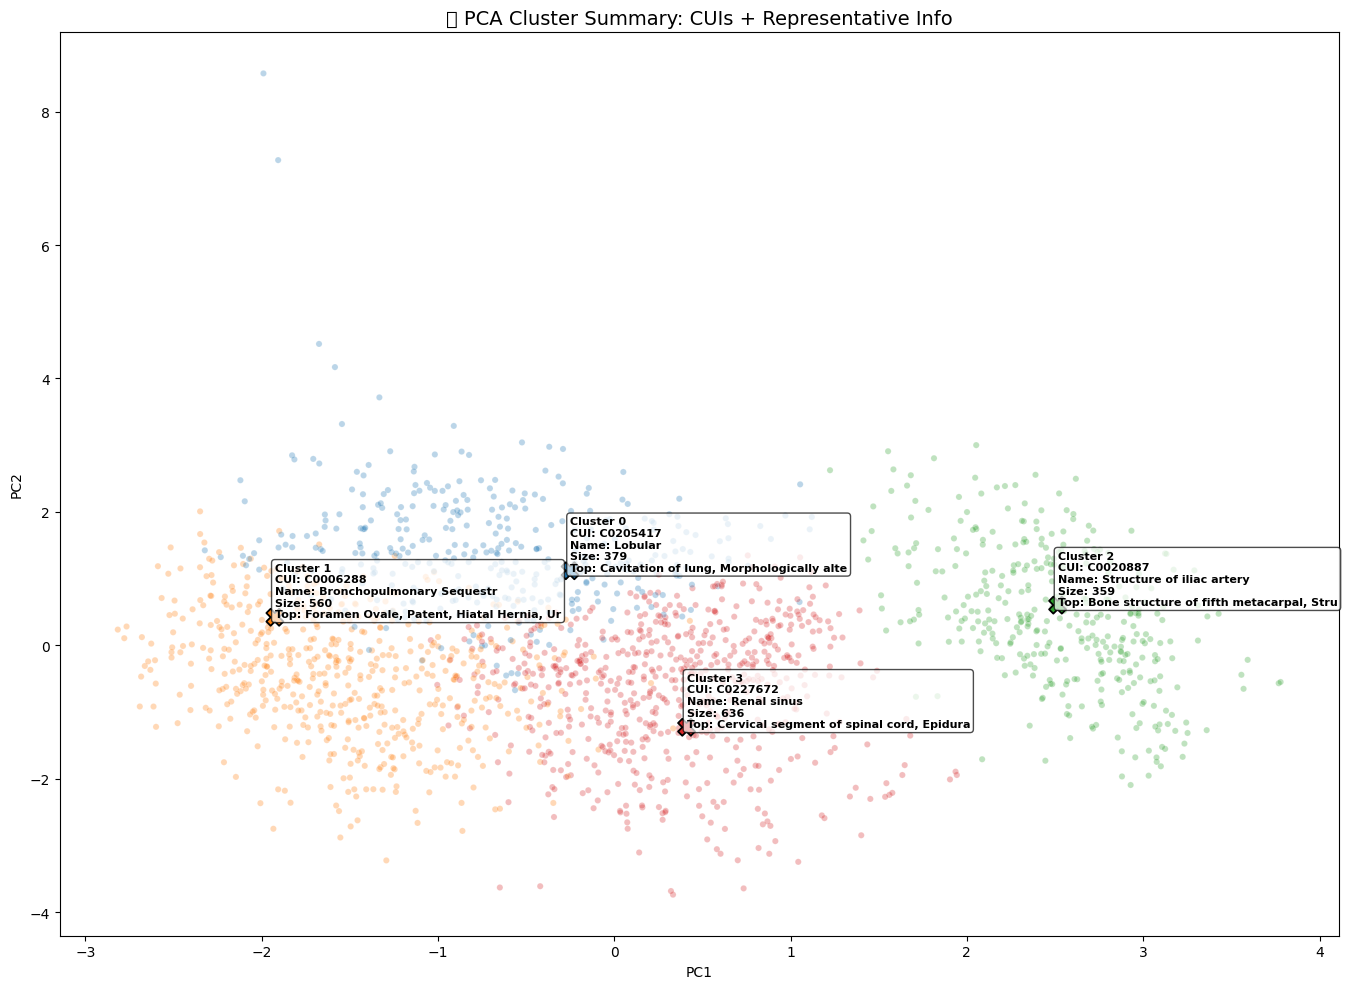

In [31]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Prepare summary info for each cluster
summary_data = {}

for cluster_id in sorted(df["cluster"].unique()):
    cluster_df = df[df["cluster"] == cluster_id]
    rep_row = cluster_df[cluster_df["is_representative"] == True].iloc[0]

    name_counts = Counter(cluster_df["Canonical name"])
    top_3_names = ", ".join([name for name, _ in name_counts.most_common(3)])

    summary_data[cluster_id] = {
        "cui": rep_row["CUI"],
        "rep_name": rep_row["Canonical name"],
        "size": len(cluster_df),
        "top3": top_3_names
    }

# Step 2: Split into representative and non-representative points
rep_coords = df[df["is_representative"] == True]
other_coords = df[df["is_representative"] == False]

# Step 3: Plot setup
plt.figure(figsize=(14, 10))

# Plot all other CUIs as small, light dots
sns.scatterplot(
    data=other_coords,
    x="PC1", y="PC2",
    hue="cluster",
    palette="tab10",
    alpha=0.3,
    legend=False,
    s=20
)

# Plot representative CUIs as Xs
sns.scatterplot(
    data=rep_coords,
    x="PC1", y="PC2",
    hue="cluster",
    palette="tab10",
    s=150,
    marker="X",
    edgecolor='black',
    linewidth=1.3,
    legend=False
)

# Step 4: Annotate representatives with detailed labels
for i in range(len(rep_coords)):
    row = rep_coords.iloc[i]
    cluster_id = row["cluster"]
    info = summary_data[cluster_id]

    label = (
        f"Cluster {cluster_id}\n"
        f"CUI: {info['cui']}\n"
        f"Name: {info['rep_name'][:25]}\n"
        f"Size: {info['size']}\n"
        f"Top: {info['top3'][:40]}"
    )

    plt.text(
        row["PC1"],
        row["PC2"],
        label,
        fontsize=8,
        weight="bold",
        bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
    )

# Final formatting
plt.title("PCA Cluster Summary: CUIs + Representative Info", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()
